## Qwen2.5-VL Grounding任务

这里介绍使用qwen2.5-vl进行grounding任务的全流程介绍。当然，你也可以使用internvl2.5或者qwen2-vl等多模态模型。


这里，我们使用[AI-ModelScope/coco](https://modelscope.cn/datasets/AI-ModelScope/coco)数据集来展示整个流程。

如果需要使用自定义数据集，需要符合以下格式：

```jsonl
{"messages": [{"role": "system", "content": "You are a helpful assistant."}, {"role": "user", "content": "<image>描述图像"}, {"role": "assistant", "content": "<ref-object><bbox>和<ref-object><bbox>正在沙滩上玩耍"}], "images": ["/xxx/x.jpg"], "objects": {"ref": ["一只狗", "一个女人"], "bbox": [[331.5, 761.4, 853.5, 1594.8], [676.5, 685.8, 1099.5, 1427.4]]}}
{"messages": [{"role": "system", "content": "You are a helpful assistant."}, {"role": "user", "content": "<image>找到图像中的<ref-object>"}, {"role": "assistant", "content": "<bbox><bbox>"}], "images": ["/xxx/x.jpg"], "objects": {"ref": ["羊"], "bbox": [[90.9, 160.8, 135, 212.8], [360.9, 480.8, 495, 532.8]]}}
{"messages": [{"role": "system", "content": "You are a helpful assistant."}, {"role": "user", "content": "<image>帮我打开谷歌浏览器"}, {"role": "assistant", "content": "Action: click(start_box='<bbox>')"}], "images": ["/xxx/x.jpg"], "objects": {"ref": [], "bbox": [[615, 226]]}}
```

ms-swift在预处理数据集时，会使用模型特有的grounding任务格式，将objects中的ref填充`<ref-object>`，bbox会根据模型类型选择是否进行0-1000的归一化，并填充`<bbox>`。例如：qwen2-vl为`f'<|object_ref_start|>羊<|object_ref_end|>'`和`f'<|box_start|>(101,201),(150,266)<|box_end|>'`（qwen2.5-vl不进行归一化，只将float型转成int型），internvl2.5分别为`f'<ref>羊</ref>'`和`f'<box>[[101, 201, 150, 266]]</box>'`等。


训练之前，你需要从main分支安装ms-swift：
```bash
# pip install git+https://github.com/modelscope/ms-swift.git

git clone https://github.com/modelscope/ms-swift.git
cd ms-swift
pip install -e .

# 如果'transformers>=4.49'已经发版，则无需从main分支安装
pip install git+https://github.com/huggingface/transformers.git
```

然后，使用以下shell进行训练。MAX_PIXELS的参数含义可以查看[这里](https://swift.readthedocs.io/en/latest/Instruction/Command-line-parameters.html#specific-model-arguments)

单卡训练：
```bash
# 显存资源：24GiB
CUDA_VISIBLE_DEVICES=0 \
MAX_PIXELS=1003520 \
swift sft \
    --model Qwen/Qwen2.5-VL-7B-Instruct \
    --dataset 'AI-ModelScope/coco#2000' \
    --train_type lora \
    --torch_dtype bfloat16 \
    --num_train_epochs 3 \
    --per_device_train_batch_size 1 \
    --per_device_eval_batch_size 1 \
    --learning_rate 1e-4 \
    --lora_rank 8 \
    --lora_alpha 32 \
    --target_modules all-linear \
    --freeze_vit true \
    --gradient_accumulation_steps 16 \
    --eval_steps 100 \
    --save_steps 100 \
    --save_total_limit 5 \
    --logging_steps 5 \
    --max_length 2048 \
    --output_dir output \
    --warmup_ratio 0.05 \
    --dataloader_num_workers 4 \
    --dataset_num_proc 4
```

然后我们将训练的模型推送到ModelScope：
```bash
CUDA_VISIBLE_DEVICES=0 swift export \
    --adapters output/vx-xxx/checkpoint-xxx \
    --push_to_hub true \
    --hub_model_id '<your-model-id>' \
    --hub_token '<your-sdk-token>' \
    --use_hf false
```

我们将训练的checkpoint推送到[swift/test_grounding](https://modelscope.cn/models/swift/test_grounding)

训练完成后，我们使用以下命令对训练时的验证集进行推理。这里`--adapters`需要替换成训练生成的last checkpoint文件夹。由于adapters文件夹中包含了训练的参数文件，因此不需要额外指定`--model`。

推理时请提前对图像进行缩放而不使用`MAX_PIXELS`或者`--max_pixels`

```bash
CUDA_VISIBLE_DEVICES=0 \
swift infer \
    --adapters swift/test_grounding \
    --stream true \
    --load_data_args true \
    --max_new_tokens 2048 \
    --dataset_num_proc 4
```

我们也可以使用代码的方式进行推理：

/root/miniconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[INFO:swift] Successfully registered `/mnt/nas2/huangjintao.hjt/work/llmscope/swift/llm/dataset/data/dataset_info.json`
[INFO:swift.hub.hub] Downloading the model from ModelScope Hub, model_id: swift/test_grounding
[WARNING:modelscope] Authentication has expired, please re-login with modelscope login --token "YOUR_SDK_TOKEN" if you need to access private models or datasets.


[WARNING:modelscope] Using branch: master as version is unstable, use with caution
[INFO:swift] Loading the model using model_dir: /mnt/data/jintao/.cache/modelscope/hub/swift/test_grounding
[INFO:swift] Successfully loaded /mnt/data/jintao/.cache/modelscope/hub/swift/test_grounding/args.json.
[INFO:swift.hub.hub] Downloading the model from ModelScope Hub, model_id: Qwen/Qwen2.5-VL-7B-Instruct


[WARNING:modelscope] Using branch: master as version is unstable, use with caution
[INFO:modelscope] Creating symbolic link /mnt/data/jintao/.cache/modelscope/hub/Qwen/Qwen2___5-VL-7B-Instruct -> /mnt/data/jintao/.cache/modelscope/hub/Qwen/Qwen2.5-VL-7B-Instruct.
[WARNING:modelscope] Failed to create symbolic link /mnt/data/jintao/.cache/modelscope/hub/Qwen/Qwen2___5-VL-7B-Instruct -> /mnt/data/jintao/.cache/modelscope/hub/Qwen/Qwen2.5-VL-7B-Instruct: [Errno 17] File exists: '/mnt/data/jintao/.cache/modelscope/hub/Qwen/Qwen2___5-VL-7B-Instruct' -> '/mnt/data/jintao/.cache/modelscope/hub/Qwen/Qwen2.5-VL-7B-Instruct'
[INFO:swift] Loading the model using model_dir: /mnt/data/jintao/.cache/modelscope/hub/Qwen/Qwen2___5-VL-7B-Instruct
[INFO:swift] Setting torch_dtype: torch.bfloat16
[WARNING:swift] Please install the package: `pip install "transformers>=4.49" -U`.
[INFO:swift] model_kwargs: {'device_map': 'cuda:0'}
The argument `trust_remote_code` is to be used with Auto classes. It has no 

output_dir: /mnt/nas2/huangjintao.hjt/work/llmscope/examples/notebook/qwen2_5-vl-grounding/images_bbox


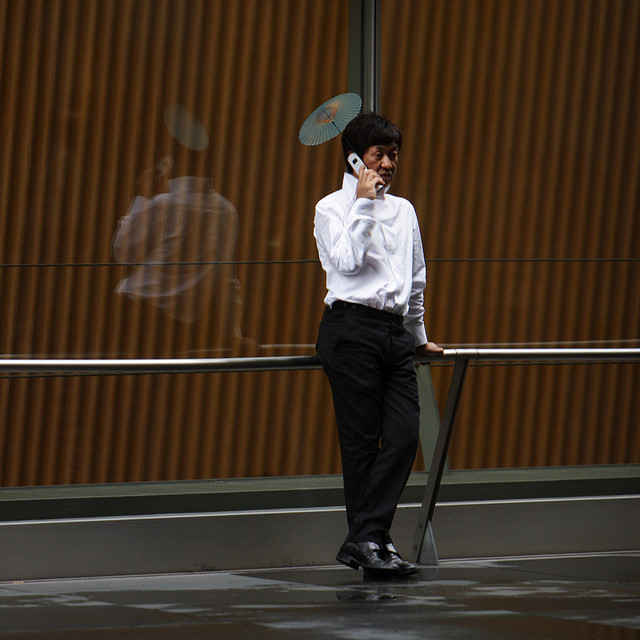

query: Task: Object Detection
response: <|object_ref_start|>cell phone<|object_ref_end|><|box_start|>(342,150),(386,197)<|box_end|>
<|object_ref_start|>person<|object_ref_end|><|box_start|>(312,110),(445,580)<|box_end|>


In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import re
from typing import Literal
from swift.llm import (
    PtEngine, RequestConfig, BaseArguments, InferRequest, safe_snapshot_download, draw_bbox, load_image, load_dataset, InferEngine
)
from IPython.display import display

def infer_stream(engine: InferEngine, infer_request: InferRequest):
    request_config = RequestConfig(max_tokens=512, temperature=0, stream=True)
    gen = engine.infer([infer_request], request_config)
    query = infer_request.messages[0]['content']
    print(f'query: {query}\nresponse: ', end='')
    response = ''
    for resp_list in gen:
        if resp_list[0] is None:
            continue
        delta = resp_list[0].choices[0].delta.content
        response += delta
        print(delta, end='', flush=True)
    print()
    return response

def draw_bbox_qwen2_vl(image, response, norm_bbox: Literal['norm1000', 'none']):
    matches = re.findall(
        r'<\|object_ref_start\|>(.*?)<\|object_ref_end\|><\|box_start\|>\((\d+),(\d+)\),\((\d+),(\d+)\)<\|box_end\|>',
        response)
    ref = []
    bbox = []
    for match_ in matches:
        ref.append(match_[0])
        bbox.append(list(match_[1:]))
    draw_bbox(image, ref, bbox, norm_bbox=norm_bbox)

# 下载权重，并加载模型
output_dir = 'images_bbox'
output_dir = os.path.abspath(os.path.expanduser(output_dir))
adapter_path = safe_snapshot_download('swift/test_grounding')
args = BaseArguments.from_pretrained(adapter_path)
engine = PtEngine(args.model, adapters=[adapter_path])

# 获取验证集并推理
_, val_dataset = load_dataset(args.dataset, split_dataset_ratio=args.split_dataset_ratio, num_proc=4, seed=args.seed)
print(f'output_dir: {output_dir}')
os.makedirs(output_dir, exist_ok=True)
for i, data in enumerate(val_dataset):
    image = data['images'][0]
    image = load_image(image['bytes'] or image['path'])
    display(image)
    response = infer_stream(engine, InferRequest(**data))
    draw_bbox_qwen2_vl(image, response, norm_bbox=args.norm_bbox)
    print('-' * 50)
    image.save(os.path.join(output_dir, f'{i}.png'))
    display(image)